In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import xgboost as xg
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score,accuracy_score,mean_absolute_percentage_error,mean_squared_error,mean_absolute_error
import warnings
import pickle
import prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import ttest_ind,levene,kruskal,mannwhitneyu,shapiro,pearsonr,spearmanr
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TRAIN.csv')

In [ ]:
df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


## Size and Shape of the dataset

In [ ]:
df.shape

(188340, 10)

## Columns of the dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


- ID : Unique identifier for each record in the dataset
- Store_id : Unique identifier for each store
- Store_Type : Categorization of the store based on its type.
- Location_Type : Classification of the store's location (eg urban, suburban)
- Region_Code : Code representing the geographical region where the store is located
- Date : The specific date on which the data was recorded.
- Holiday : Indicator of whether the date was a holiday ( 1 : yes, 0 : No)
- Discount : Indicates whether a discount was offered on the given date ( Yes/No)
- #Order : The number of orderse received by the store on the specified day.
- Sales : Indicates whether a discount was offered on the given date(Yes/No)

## Converting the date field from object to date time format

In [ ]:
df['Date'] = pd.to_datetime(df['Date'],
                            errors = 'coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ID             188340 non-null  object        
 1   Store_id       188340 non-null  int64         
 2   Store_Type     188340 non-null  object        
 3   Location_Type  188340 non-null  object        
 4   Region_Code    188340 non-null  object        
 5   Date           188340 non-null  datetime64[ns]
 6   Holiday        188340 non-null  int64         
 7   Discount       188340 non-null  object        
 8   #Order         188340 non-null  int64         
 9   Sales          188340 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 14.4+ MB


## Checking for missing values

In [ ]:
df.isna().sum()

,0
ID,0
Store_id,0
Store_Type,0
Location_Type,0
Region_Code,0
Date,0
Holiday,0
Discount,0
#Order,0
Sales,0


## Observation
- There are no missing values in the dateset.

## Checking for outliers

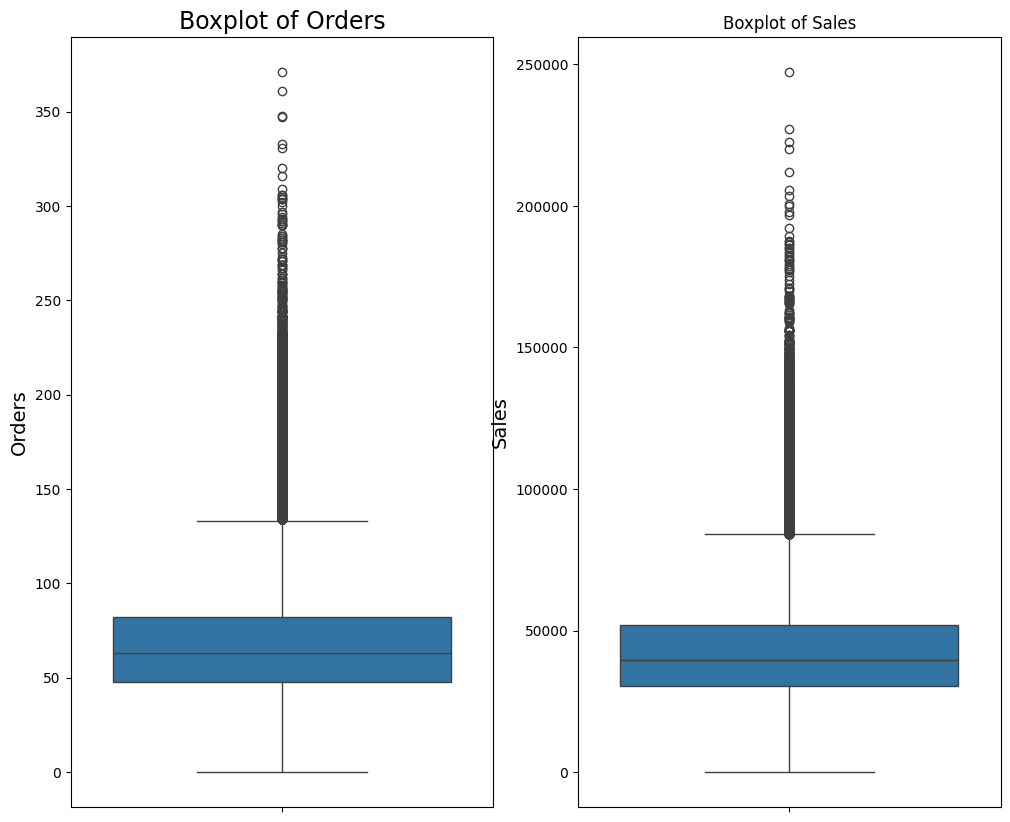

In [ ]:
plt.figure(figsize = (12,10))
plt.subplot(1,2,1)
plt.title('Boxplot of Orders',fontsize = 17)
sns.boxplot(data = df,y = '#Order')
plt.ylabel('Orders',fontsize = 14)

plt.subplot(1,2,2)
plt.title('Boxplot of Sales')
sns.boxplot(data = df, y = 'Sales')
plt.ylabel('Sales',fontsize = 14)
plt.show()

## Statistical Analysis

In [ ]:
df.describe()

,Store_id,Date,Holiday,#Order,Sales
count,188340.000000,188340,188340.000000,188340.000000,188340.000000
mean,183.000000,2018-09-15 12:00:00.000000256,0.131783,68.205692,42784.327982
min,1.000000,2018-01-01 00:00:00,0.000000,0.000000,0.000000
25%,92.000000,2018-05-09 18:00:00,0.000000,48.000000,30426.000000
50%,183.000000,2018-09-15 12:00:00,0.000000,63.000000,39678.000000
75%,274.000000,2019-01-22 06:00:00,0.000000,82.000000,51909.000000
max,365.000000,2019-05-31 00:00:00,1.000000,371.000000,247215.000000
std,105.366308,NaN,0.338256,30.467415,18456.708302


In [ ]:
df.describe(include = object)

,ID,Store_Type,Location_Type,Region_Code,Discount
count,188340,188340,188340,188340,188340
unique,188340,4,5,4,2
top,T1000001,S1,L1,R1,No
freq,1,88752,85140,63984,104051


## Observations
- The most frequent store type is S1 and location is L1 and region is R1.
- Average sales for a shop on a day is 42784.327982
- Average orders for a shop on a day is 68.205692

## Univariate Analysis

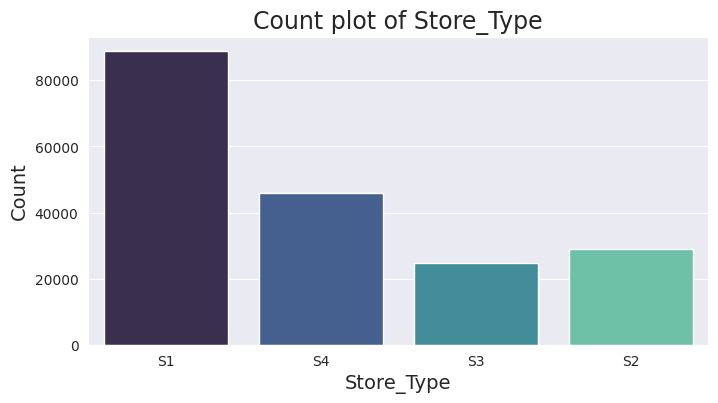

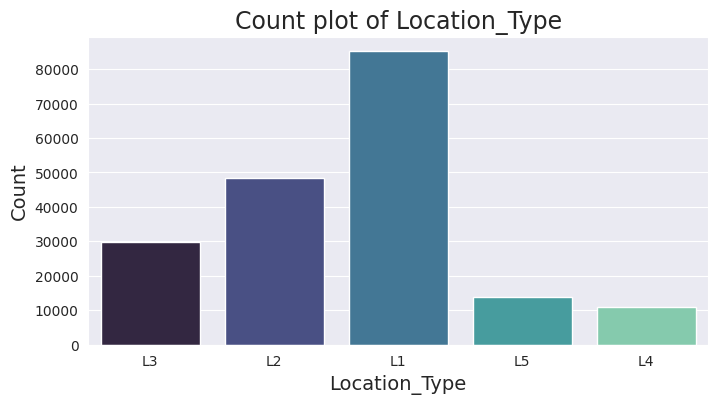

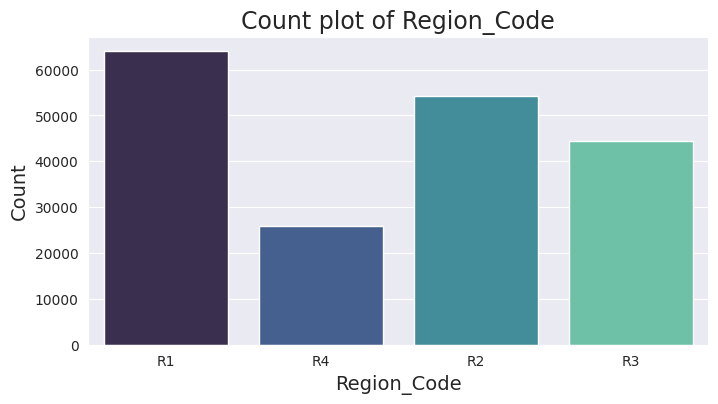

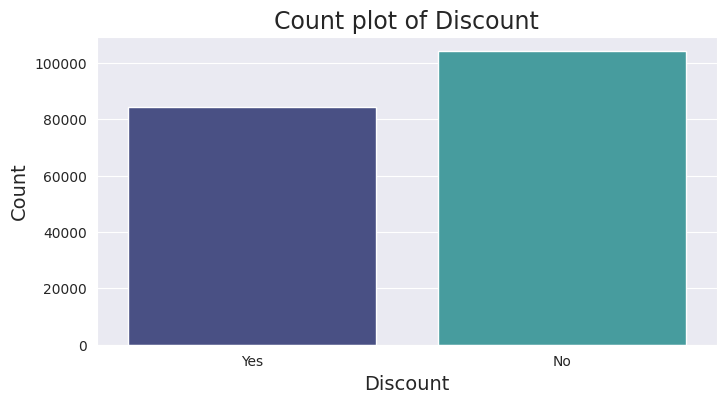

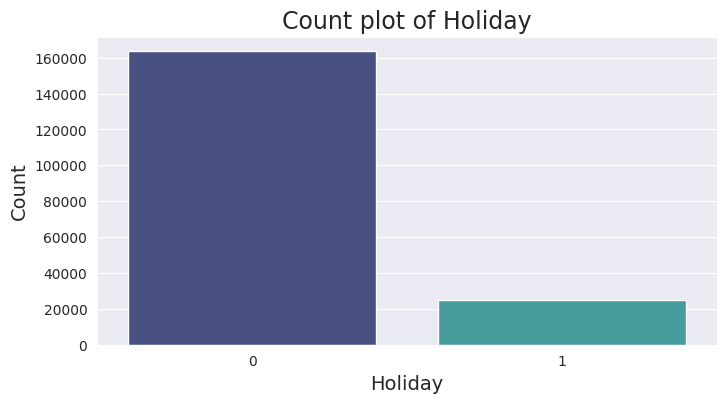

In [ ]:
cat_cols = ['Store_Type','Location_Type','Region_Code','Discount','Holiday']
for i in cat_cols:
    a = df[i].value_counts().reset_index(name = 'count')
    plt.figure(figsize = (8,4))
    sns.set_style('darkgrid')
    sns.countplot(x = df[i],palette='mako')
    plt.title(f'Count plot of {i}',fontsize = 17)
    plt.xlabel(i,fontsize = 14)
    plt.ylabel('Count',fontsize = 14)
    plt.show()

## Observations
- In the data there is less number of Holidays as compared to non Holidays
- Most of the sales are done without discounts

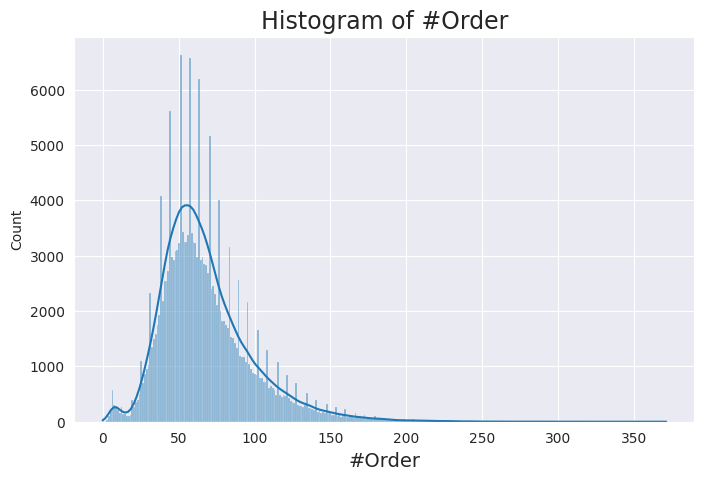

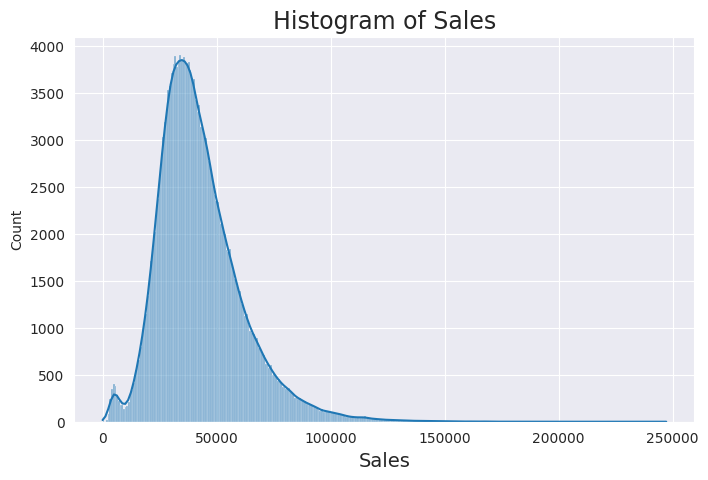

In [ ]:
num_cols = ['#Order','Sales']

for i in range(len(num_cols)):
    plt.figure(figsize = (8,5))
    plt.title(f'Histogram of {num_cols[i]}',fontsize = 17)
    sns.histplot(data = df, x = num_cols[i],kde = True,
                 palette = 'mako')
    plt.xlabel(num_cols[i],fontsize = 14)
plt.show()

## Bivariate Analysis

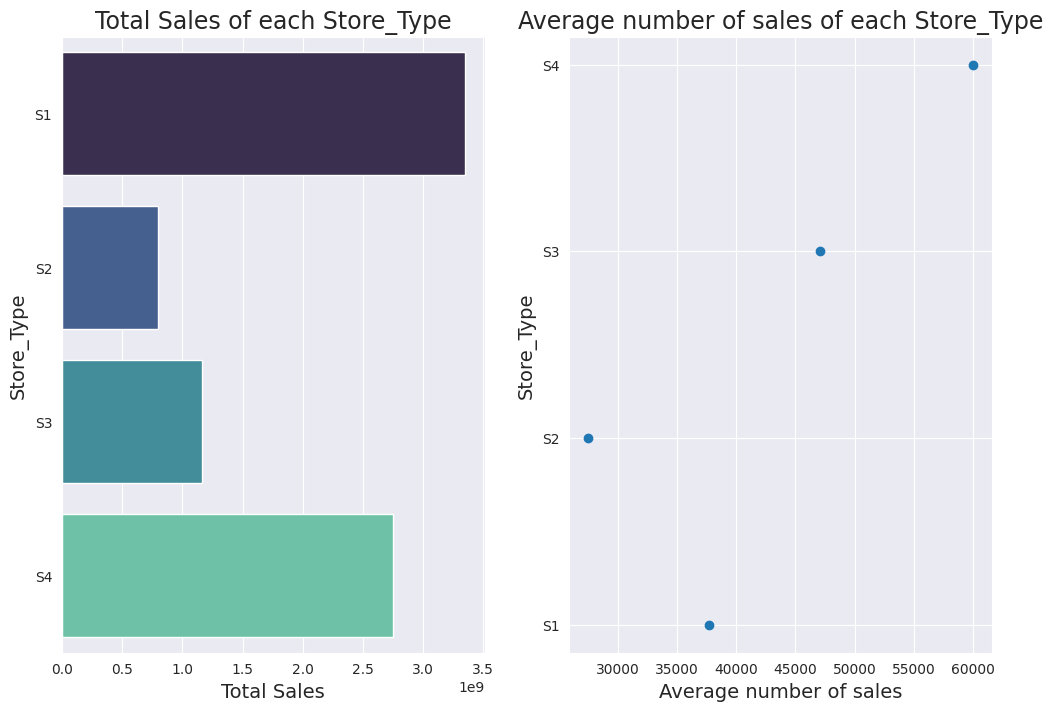

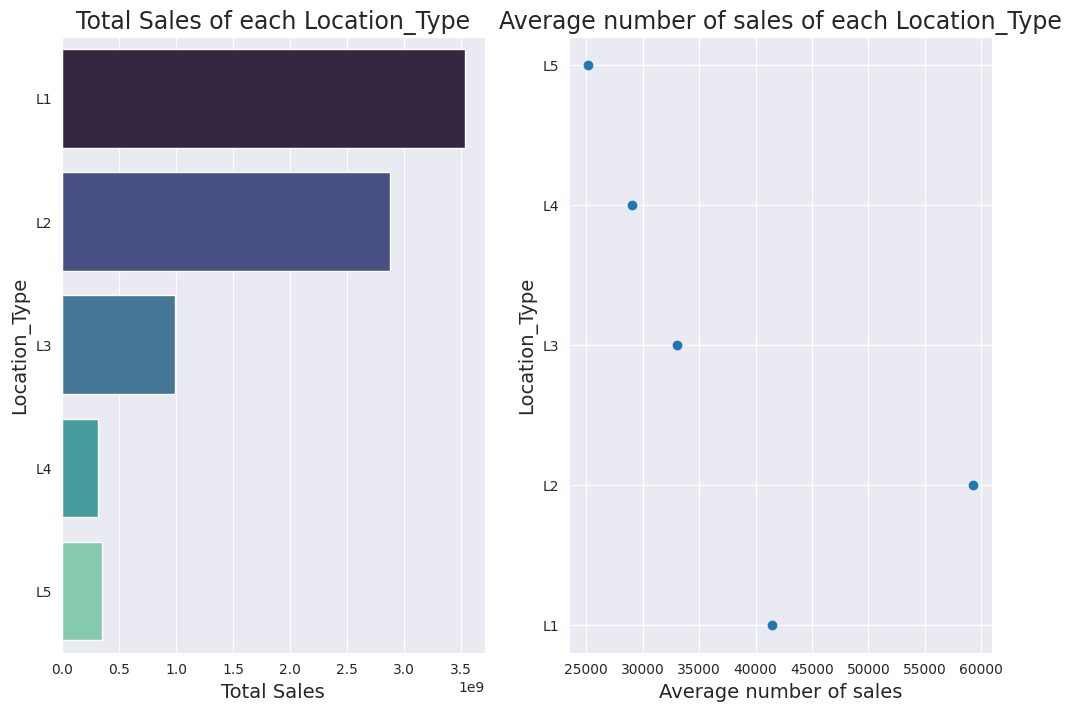

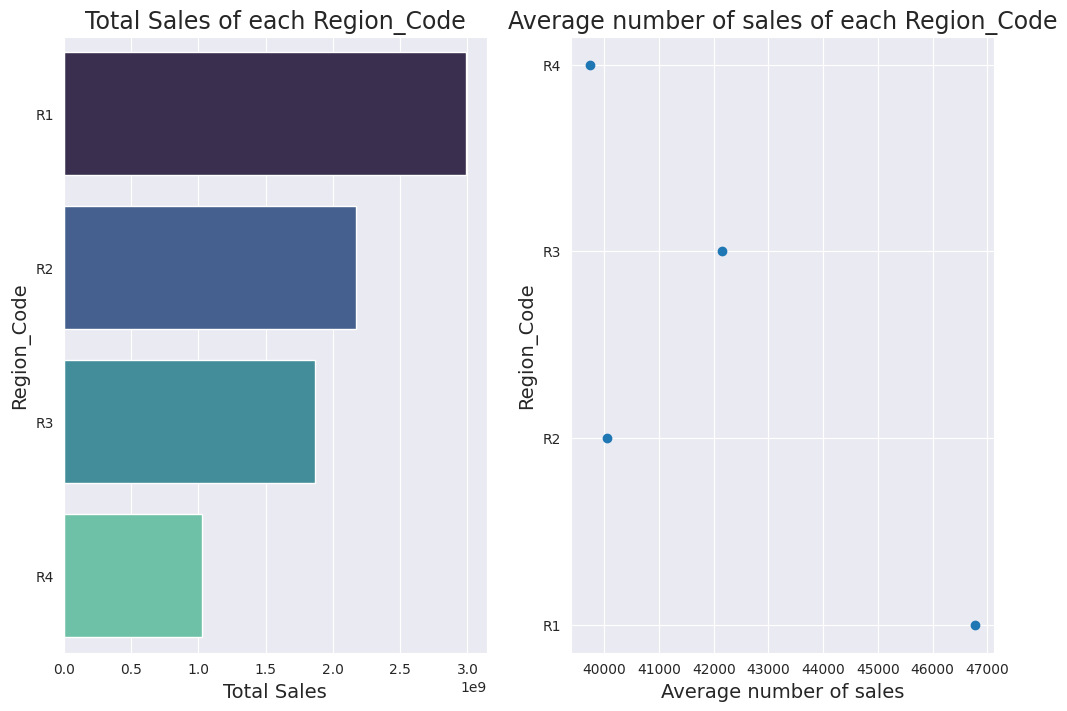

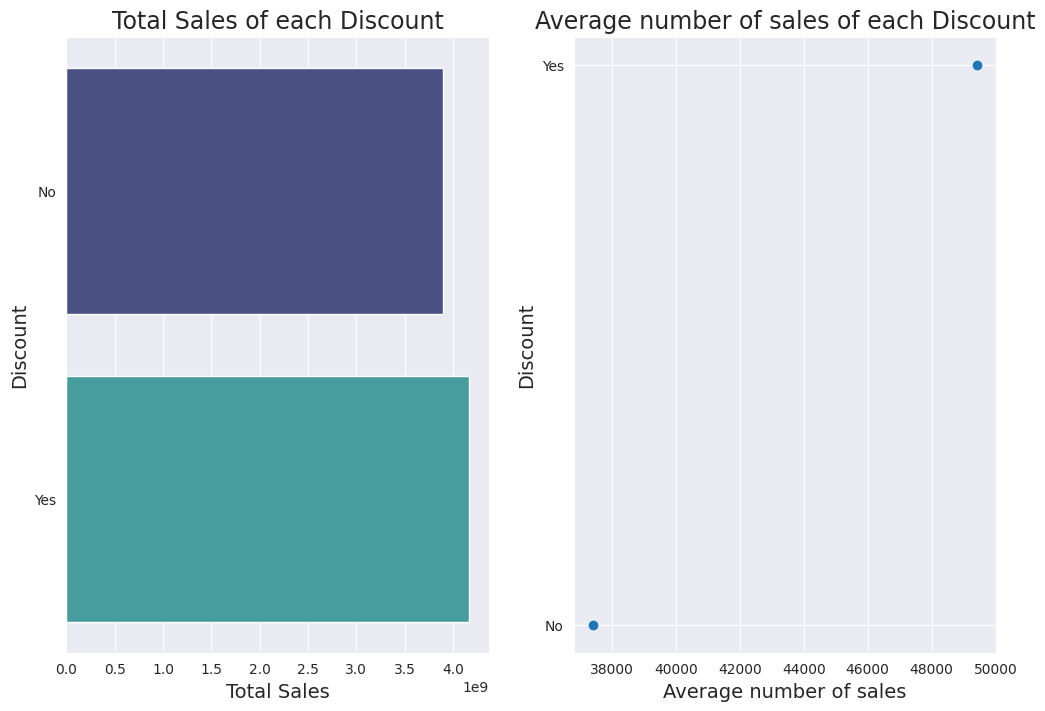

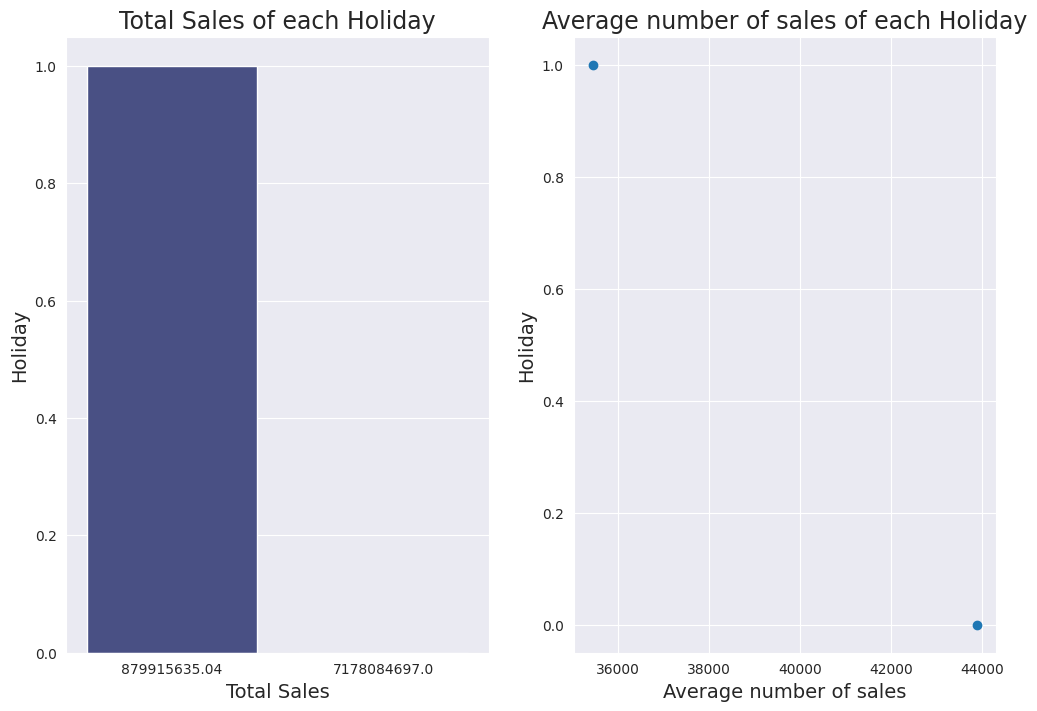

In [ ]:
for i in range(len(cat_cols)):
    a = df.groupby(cat_cols[i])['Sales'].aggregate(['sum','mean']).reset_index()
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.title(f'Total Sales of each {cat_cols[i]}',fontsize = 17)
    sns.barplot(data =a,x = 'sum',y = cat_cols[i],palette = 'mako')
    plt.xlabel('Total Sales',fontsize = 14)
    plt.ylabel(cat_cols[i],fontsize = 14)

    plt.subplot(1,2,2)
    plt.scatter(x=a['mean'],y = a[cat_cols[i]])
    plt.title(f'Average number of sales of each {cat_cols[i]}',
              fontsize = 17)
    plt.xlabel('Average number of sales',fontsize = 14)
    plt.ylabel(cat_cols[i],fontsize = 14)
    plt.show()

## Observations
- Discounts have more sales.
- R1 regions have the highest number of sales.
- L1 Locations have the highest sales.
- S1 store type has the highest sales.


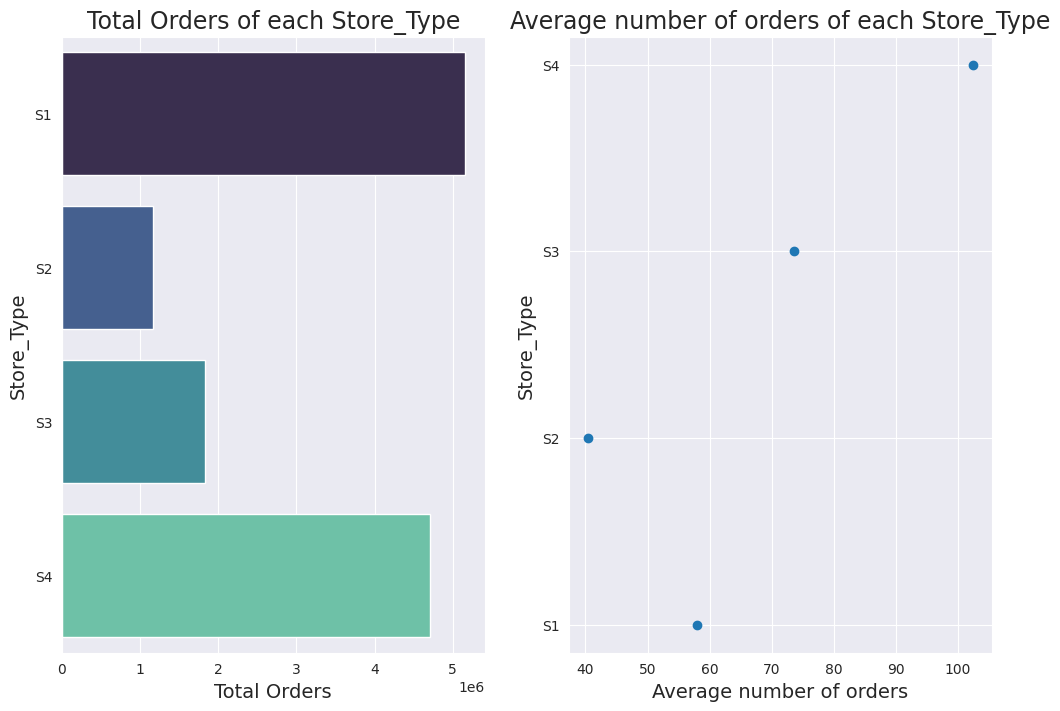

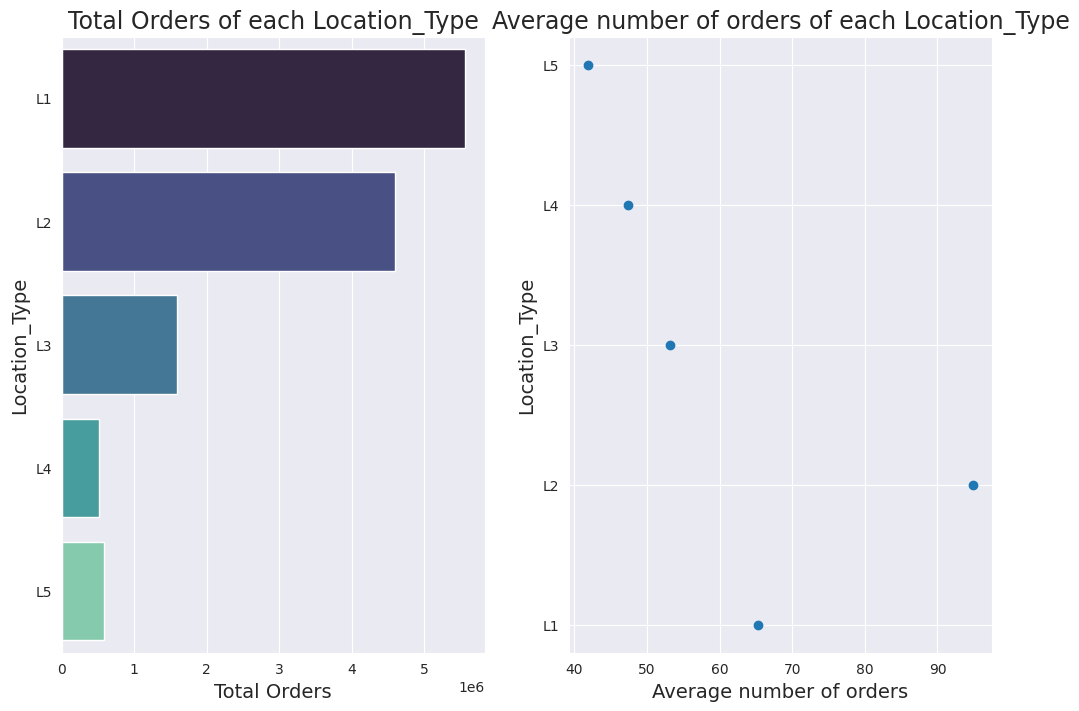

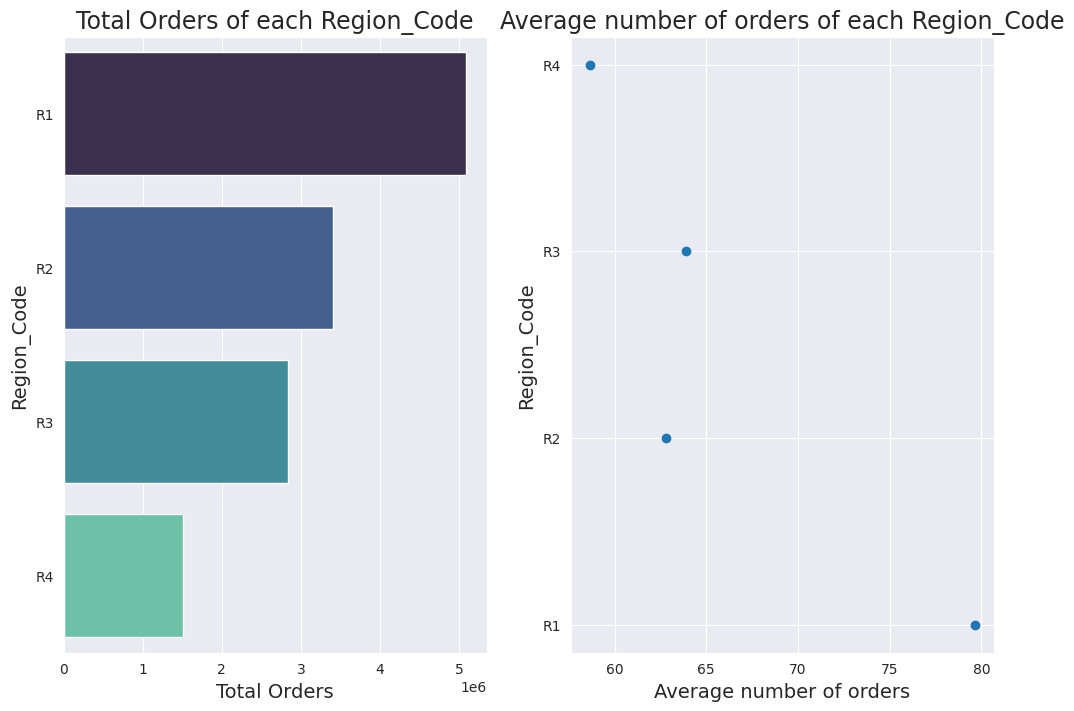

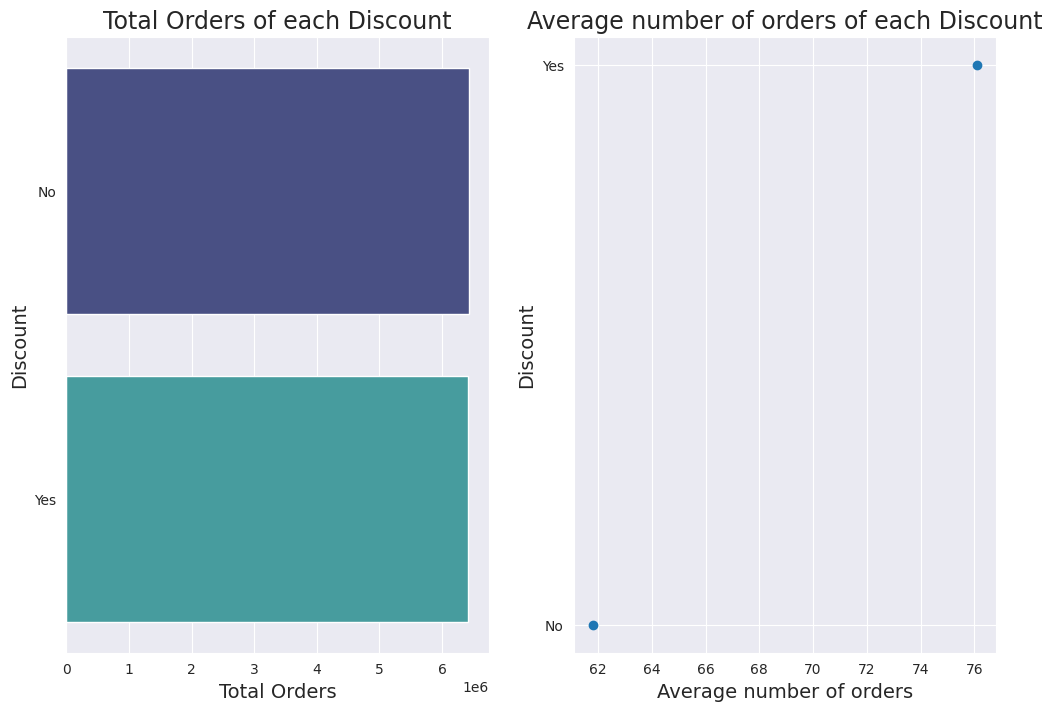

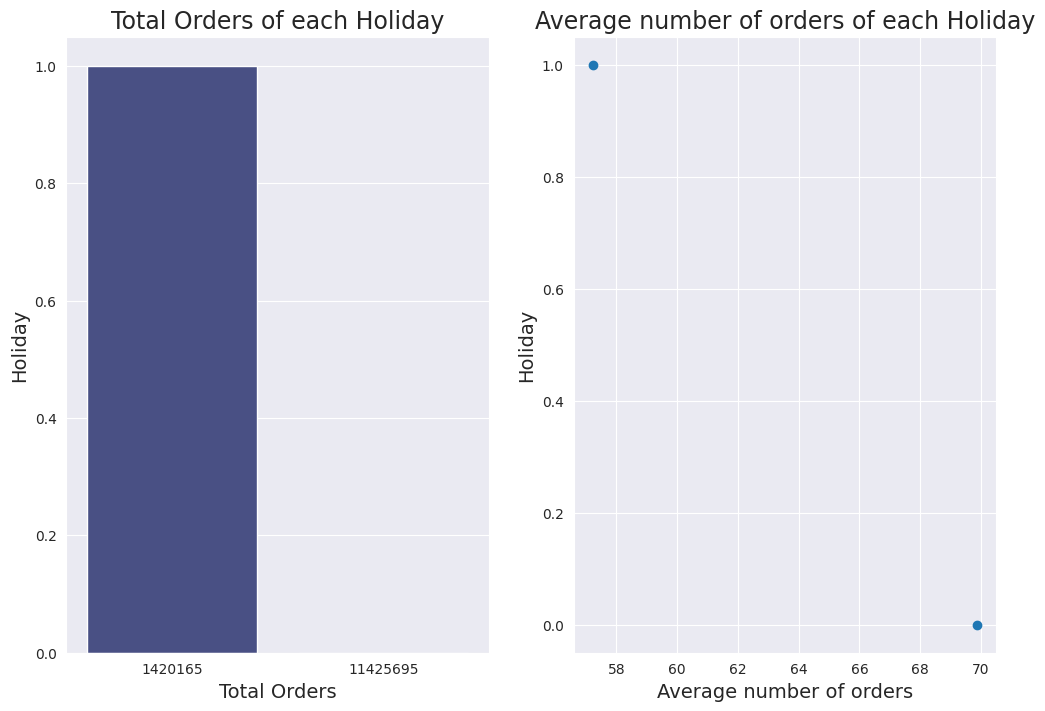

In [ ]:
for i in range(len(cat_cols)):
    a = df.groupby(cat_cols[i])['#Order'].aggregate(['sum','mean']).reset_index()
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.title(f'Total Orders of each {cat_cols[i]}',fontsize = 17)
    sns.barplot(data =a,x = 'sum',y = cat_cols[i],palette = 'mako')
    plt.xlabel('Total Orders',fontsize = 14)
    plt.ylabel(cat_cols[i],fontsize = 14)

    plt.subplot(1,2,2)
    plt.scatter(x=a['mean'],y = a[cat_cols[i]])
    plt.title(f'Average number of orders of each {cat_cols[i]}',
              fontsize = 17)
    plt.xlabel('Average number of orders',fontsize = 14)
    plt.ylabel(cat_cols[i],fontsize = 14)
    plt.show()

## Observations
- R1 region have the highest orders
- L1 Locations have the highest orders
- S1 have the highest orders

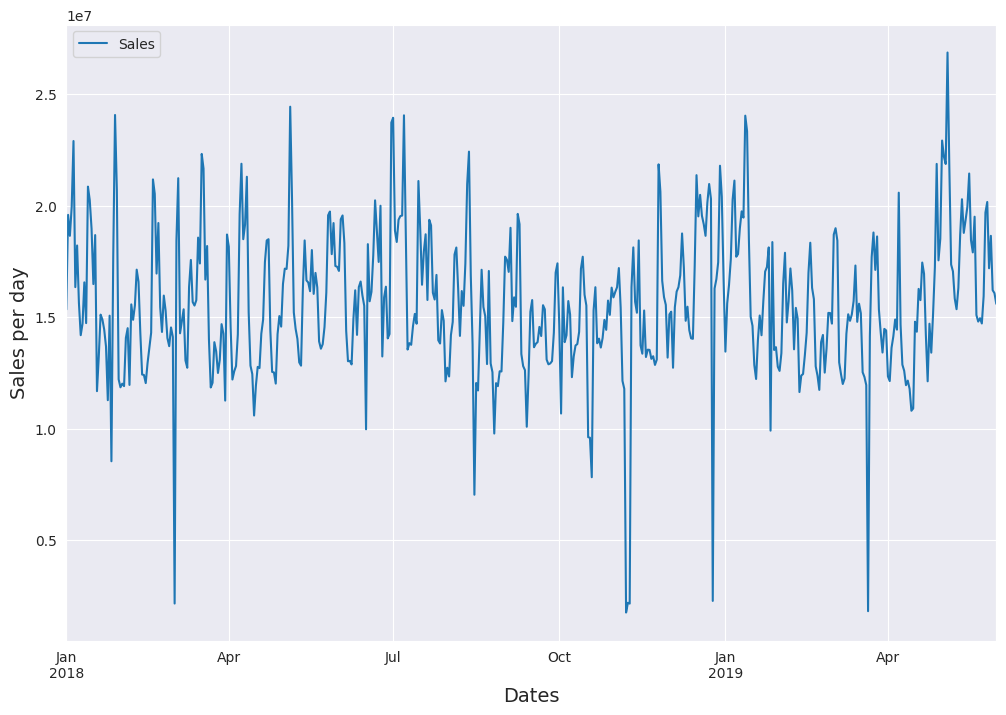

In [ ]:
sales_data = df.groupby('Date')['Sales'].aggregate('sum').reset_index()
sales_data  = sales_data.set_index('Date')
plt.rcParams['figure.figsize']=(12,8)
sales_data.plot()
plt.xlabel('Dates',fontsize = 14)
plt.ylabel('Sales per day',fontsize = 14)
plt.show()

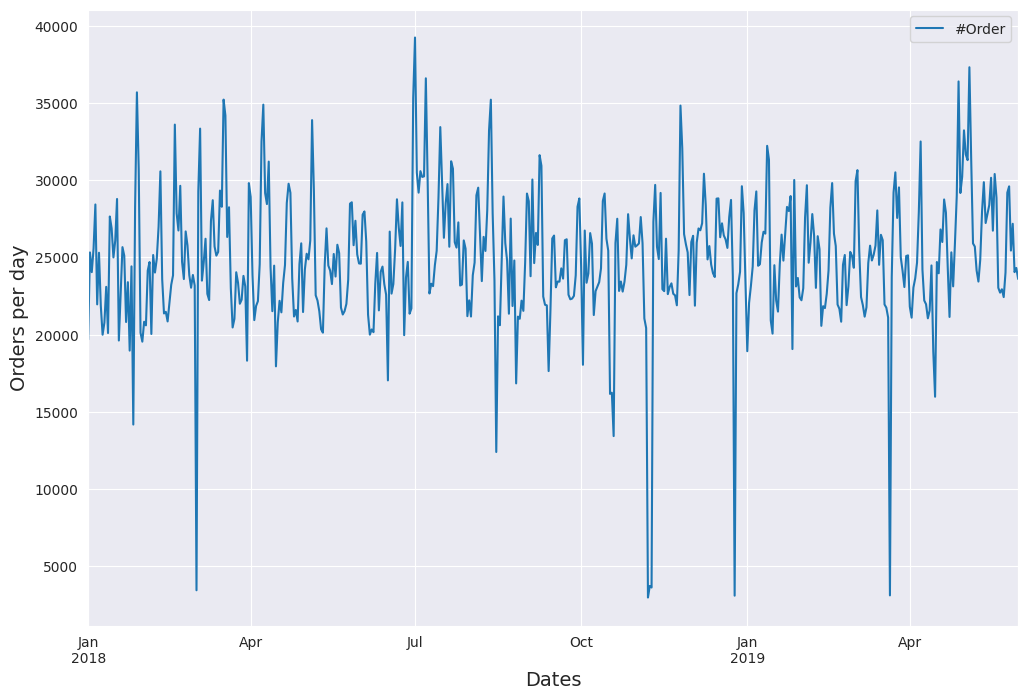

In [ ]:
order_data = df.groupby('Date')['#Order'].aggregate('sum').reset_index()
order_data = order_data.set_index('Date')
plt.rcParams['figure.figsize']=(12,8)
order_data.plot()
plt.xlabel('Dates',fontsize =14)
plt.ylabel('Orders per day',fontsize = 14)
plt.show()

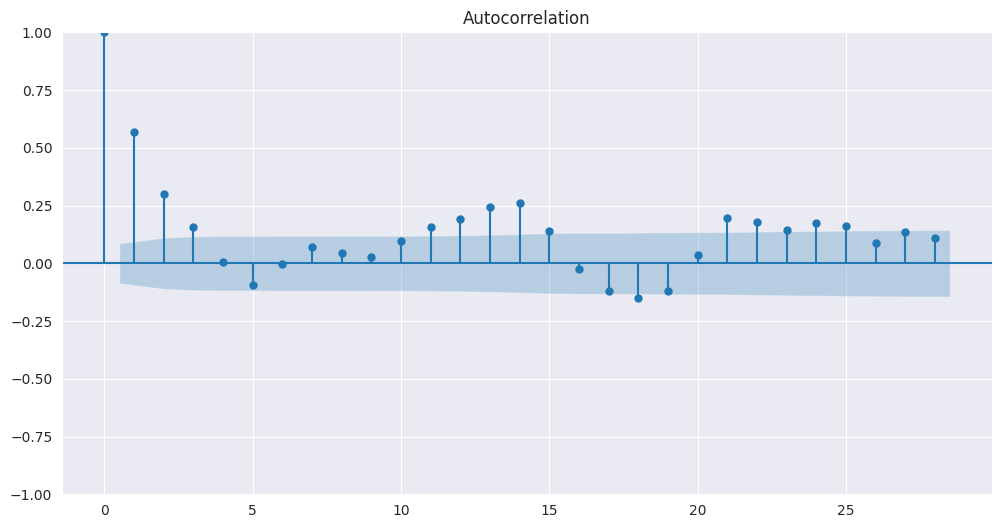

In [ ]:
plt.rcParams['figure.figsize'] = (12,6)
plot_acf(sales_data);

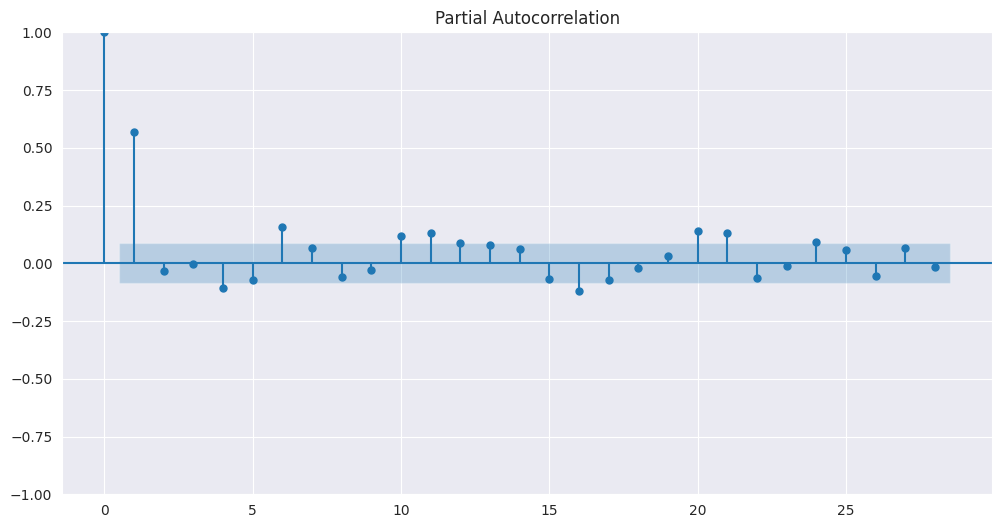

In [ ]:
plt.rcParams['figure.figsize'] = (12,6)
plot_pacf(sales_data);

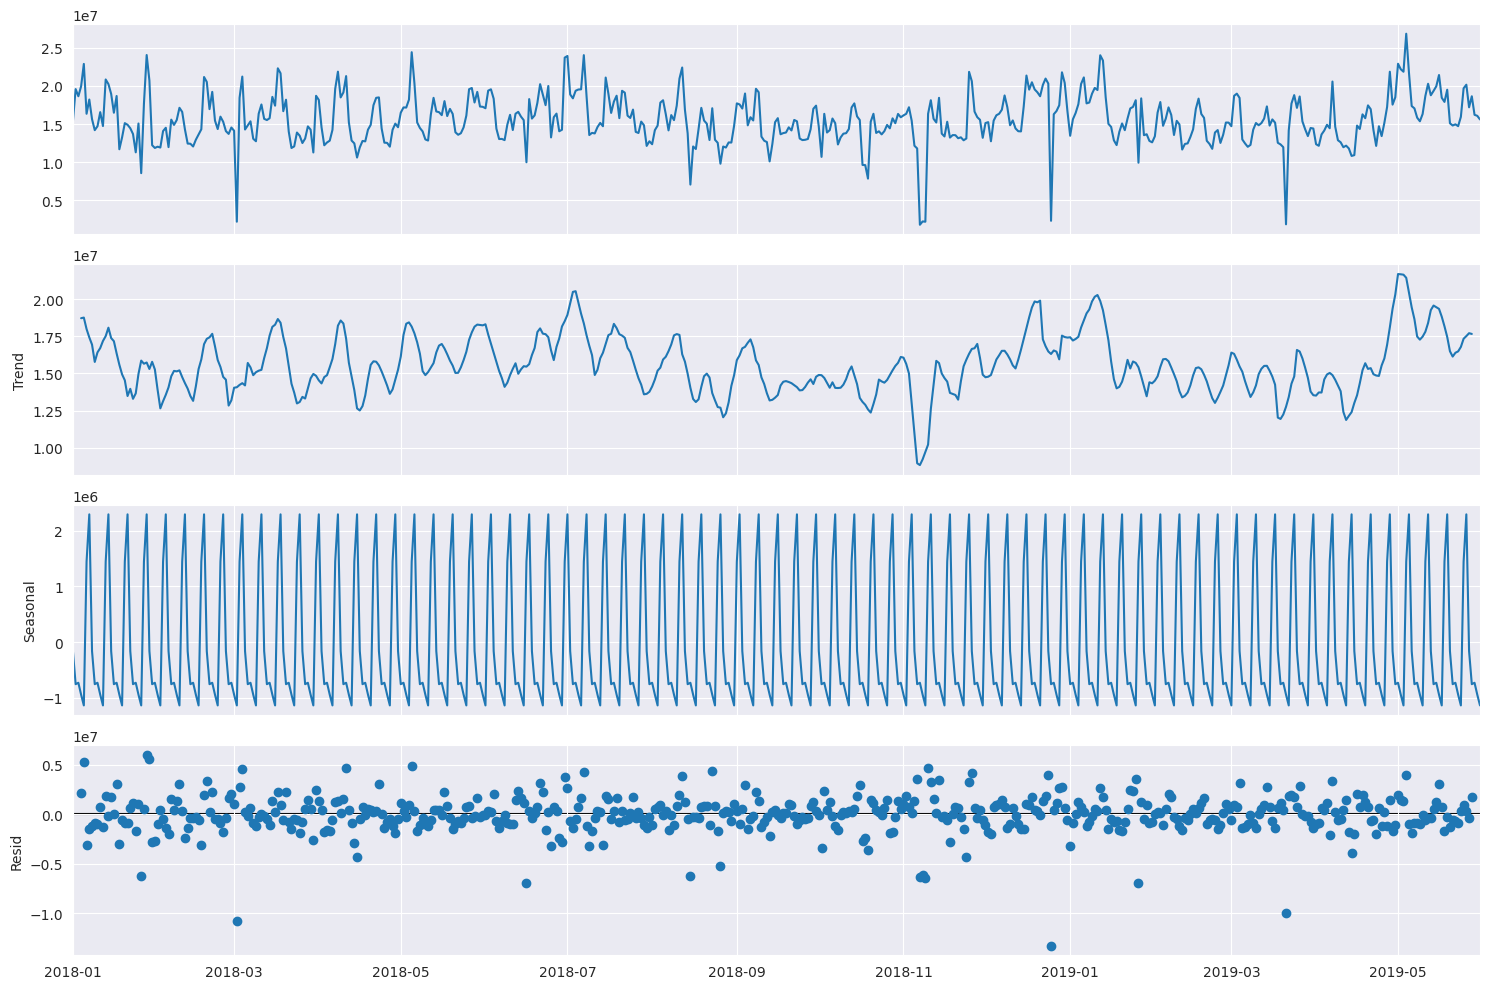

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)
decomposition = sm.tsa.seasonal_decompose(sales_data,
                                                model = 'additive',
                                                period = 7)
decomposition.plot();

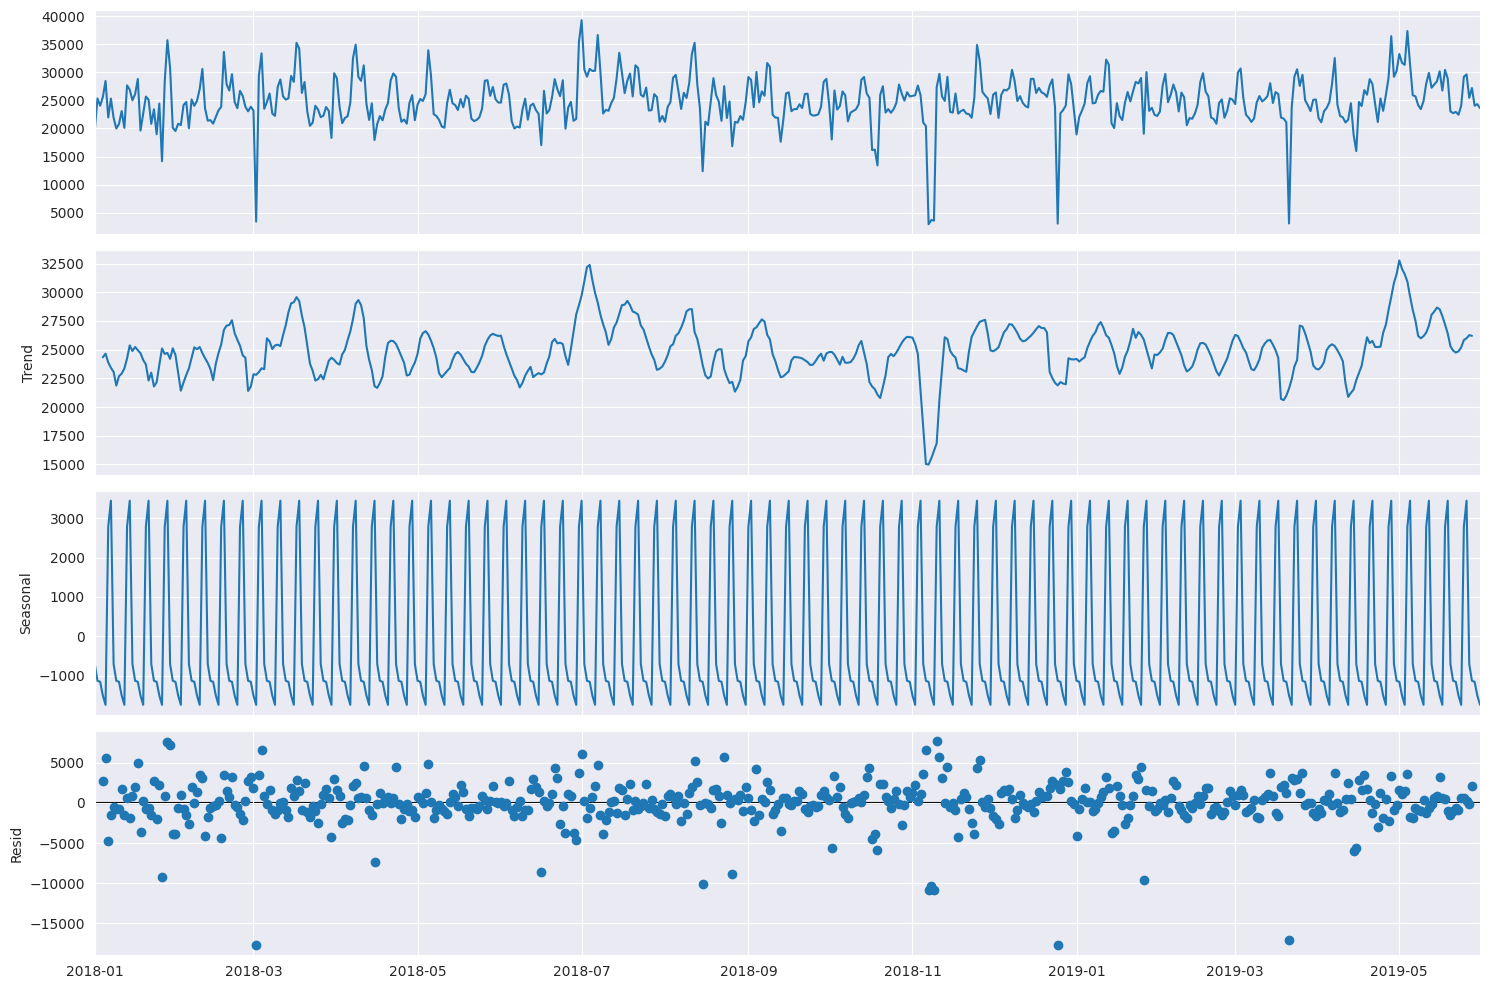

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)
decomposition = sm.tsa.seasonal_decompose(order_data,
                                                model = 'additive',
                                                period = 7)
decomposition.plot();

## Outlier Treatment


In [ ]:
q3 = df['Sales'].quantile(0.75)
q1 = df['Sales'].quantile(0.25)
iqr = q3-q1
lower = max(0,q1-1.5*iqr)
upper = 1.5*iqr+q3
sales_out_data = df.loc[(df['Sales']>=lower)&(df['Sales']<=upper)]

## Hypothesis Testing

In [ ]:
discount = sales_out_data.loc[sales_out_data['Discount']=='Yes','Sales']
no_discount = sales_out_data.loc[sales_out_data['Discount']=='No','Sales']

## Checking for homogenity

In [ ]:
Ho = 'Variance is equal'
Ha = 'Variance is not equal'
lstat,pval = levene(discount,no_discount)
if pval<0.05:
    print("Reject Ho")
    print(Ha)
else:
    print('Failed to reject Ho')
    pritn(Ho)

Reject Ho
Variance is not equal


#### Since the data is not homogenous we cannot use ttest instead we will use mannwhitneyu test

In [ ]:
#Case 1 :
Ho = 'Sales of stores offering discount have same sales as those who are not offering discount'
Ha = 'Sales of stores offering discount do not have same sales as those who are not offering discount'
t_stat,pval = mannwhitneyu(discount,no_discount)
print(pval)
if pval<0.05:
    print("Reject Ho")
    print(Ha)
else:
    print('Failed to reject Ho')
    print(Ho)

0.0
Reject Ho
Sales of stores offering discount do not have same sales as those who are not offering discount


In [ ]:
#Case 2:
Ho = 'Sales of stores offering discount have same sales as those who are not offering discount'
Ha = 'Sales of stores offering discount have more sales as those who are not offering discount'
t_stat,pval = mannwhitneyu(discount,no_discount,alternative = 'greater')
print(pval)
if pval<0.05:
    print("Reject Ho")
    print(Ha)
else:
    print('Failed to reject Ho')
    print(Ho)

0.0
Reject Ho
Sales of stores offering discount have more sales as those who are not offering discount


## Effect of holidays on Sales
## Checking for assumptions of ttest

In [ ]:
## Checking for homogenity
holidays = sales_out_data.loc[sales_out_data['Holiday']==1,'Sales']
non_holidays = sales_out_data.loc[sales_out_data['Holiday']==0,'Sales']
Ho = 'Variance is equal'
Ha = 'Variance is not equal'
lstat,pval = levene(holidays,non_holidays)
if pval<0.05:
    print("Reject Ho")
    print(Ha)
else:
    print('Failed to reject Ho')
    print(Ho)

Reject Ho
Variance is not equal


#### Since the data is not homogenous we cannot use ttest instead we will use mannwhitneyu test
#### Case 1:

In [ ]:
Ho = 'There is no effect of Holidays on sales of the stores'
Ha = 'There is effect of Holidays on sales of the stores'
t_stat,pval = mannwhitneyu(holidays,non_holidays)
print(pval)
if pval<0.05:
    print("Reject Ho")
    print(Ha)
else:
    print('Failed to reject Ho')
    print(Ho)

0.0
Reject Ho
There is effect of Holidays on sales of the stores


#### Case 2:

In [ ]:
Ho = 'There is no effect of Holidays on sales of the stores'
Ha = 'Less sales are done on Holidays as compared to non_holidays'
t_stat,pval = mannwhitneyu(holidays,non_holidays,alternative = 'less')
print(pval)
if pval<0.05:
    print("Reject Ho")
    print(Ha)
else:
    print('Failed to reject Ho')
    print(Ho)

0.0
Reject Ho
Less sales are done on Holidays as compared to non_holidays


## Sales difference across store types

In [ ]:
s1 = sales_out_data.loc[sales_out_data['Store_Type']=='S1','Sales']
s2 = sales_out_data.loc[sales_out_data['Store_Type']=='S2','Sales']
s3 = sales_out_data.loc[sales_out_data['Store_Type']=='S3','Sales']
s4 = sales_out_data.loc[sales_out_data['Store_Type']=='S4','Sales']

### Checking for the assumptions of ANOVA test

In [ ]:
#Checking if all the stores are following gaussian distribution or not
Ho = 'Store type 1 is gaussian'
Ha = 'Store type 1 is not gaussian'
test_stat,pval = shapiro(s1)
if pval<0.05:
    print('Reject Ho')
    print(Ha)
else:
    print('Failed to reject Ho')
    print(Ho)

Reject Ho
Store type 1 is not gaussian


In [ ]:
Ho = 'Store type 2 is gaussian'
Ha = 'Store type 2 is not gaussian'
test_stat,pval = shapiro(s2)
if pval<0.05:
    print('Reject Ho')
    print(Ha)
else:
    print('Failed to reject Ho')
    print(Ho)

Reject Ho
Store type 2 is not gaussian


In [ ]:
Ho = 'Store type 3 is gaussian'
Ha = 'Store type 3 is not gaussian'
test_stat,pval = shapiro(s3)
if pval<0.05:
    print('Reject Ho')
    print(Ha)
else:
    print('Failed to reject Ho')
    print(Ho)

Reject Ho
Store type 3 is not gaussian


In [ ]:
Ho = 'Store type 4 is gaussian'
Ha = 'Store type 4 is not gaussian'
test_stat,pval = shapiro(s4)
if pval<0.05:
    print('Reject Ho')
    print(Ha)
else:
    print('Failed to reject Ho')
    print(Ho)

Reject Ho
Store type 4 is not gaussian


#### Since all the store types do not follow gaussian distribution we will perform Kruskal Test

In [ ]:
Ho = 'All the stores experience the same sales volume'
Ha = 'All the stores do not experience the same sales volume'
k_stat,pval = kruskal(s1,s2,s3,s4)
print(pval)
if pval<0.05:
    print('Reject Ho')
    print(Ha)
else:
    print('Failed to reject Ho')
    print(Ho)

0.0
Reject Ho
All the stores do not experience the same sales volume


## Checking for regional sales variability

In [ ]:
r1 = sales_out_data.loc[sales_out_data['Region_Code']=='R1','Sales']
r2 = sales_out_data.loc[sales_out_data['Region_Code']=='R2','Sales']
r3 = sales_out_data.loc[sales_out_data['Region_Code']=='R3','Sales']
r4 = sales_out_data.loc[sales_out_data['Region_Code']=='R4','Sales']

## Checking for assumptions of ANOVA

In [ ]:
#Checking if all the regions follow gaussian distribution
Ho = 'Regional code 1 is gaussian'
Ha = 'Regional code 1 is not gaussian'
test_stat,pval = shapiro(r1)
if pval<0.05:
    print('Reject Ho')
    print(Ha)
else:
    print('Failed to reject Ho')
    print(Ho)

Reject Ho
Regional code 1 is not gaussian


In [ ]:
Ho = 'Regional code 2 is gaussian'
Ha = 'Regional code 2 is not gaussian'
test_stat,pval = shapiro(r2)
if pval<0.05:
    print('Reject Ho')
    print(Ha)
else:
    print('Failed to reject Ho')
    print(Ho)

Reject Ho
Regional code 2 is not gaussian


In [ ]:
Ho = 'Regional code 3 is gaussian'
Ha = 'Regional code 3 is not gaussian'
test_stat,pval = shapiro(r3)
if pval<0.05:
    print('Reject Ho')
    print(Ha)
else:
    print('Failed to reject Ho')
    print(Ho)

Reject Ho
Regional code 3 is not gaussian


In [ ]:
Ho = 'Regional code 4 is gaussian'
Ha = 'Regional code 4 is not gaussian'
test_stat,pval = shapiro(r4)
if pval<0.05:
    print('Reject Ho')
    print(Ha)
else:
    print('Failed to reject Ho')
    print(Ho)

Reject Ho
Regional code 4 is not gaussian


#### Since all the regions are not following gaussian distribution we will perform Kruskal

In [ ]:
Ho = 'All the regions have similar sales'
Ha = 'All the regions do not have similar sales'
k_stat,pval = kruskal(r1,r2,r3,r4)
print(pval)
if pval<0.05:
    print('Reject Ho')
    print(Ha)
else:
    print('Failed to reject Ho')
    print(Ho)

0.0
Reject Ho
All the regions do not have similar sales


## Pearson and Spearman correlation between Orders and Sales

In [ ]:
Ho = 'There is no correlation between Order and Sales'
Ha = 'There is correlation between Order and Sales'
p_coeff,pval = pearsonr(sales_out_data['#Order'],sales_out_data['Sales'])
print(pval,p_coeff)
if pval<0.05:
    print('Rejct Ho')
    print(Ha)
else:
    print('Failed to reject Ho')
    print(Ho)

0.0 0.9264826935600469
Rejct Ho
There is correlation between Order and Sales


In [ ]:
Ho = 'There is no correlation between Order and Sales'
Ha = 'There is correlation between Order and Sales'
#Spearman Correlation
coeff,pval = spearmanr(sales_out_data['#Order'],sales_out_data['Sales'])
print(pval,coeff)
if pval<0.05:
    print('Rejct Ho')
    print(Ha)
else:
    print('Failed to reject Ho')
    print(Ho)

0.0 0.931824064950081
Rejct Ho
There is correlation between Order and Sales


## Data preprocessing
## Label Encoding Discount,Store_type,Location_type,Region_Code columns

In [ ]:
le = preprocessing.LabelEncoder()
sales_out_data['Store_Type'] = le.fit_transform(sales_out_data['Store_Type'])
sales_out_data['Region_Code'] = le.fit_transform(sales_out_data['Region_Code'])
sales_out_data['Location_Type'] = le.fit_transform(sales_out_data['Location_Type'])
sales_out_data['Discount'] = le.fit_transform(sales_out_data['Discount'])
reg_data = sales_out_data.drop(['ID','Store_id','Date'],axis = 1)

## For test data we are also doing the same steps

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TEST_FINAL.csv')
t_reg = test.drop(['ID','Store_id','Date'],axis = 1)
# Label encoding
le = preprocessing.LabelEncoder()
t_reg['Store_Type'] = le.fit_transform(t_reg['Store_Type'])
t_reg['Region_Code'] = le.fit_transform(t_reg['Region_Code'])
t_reg['Location_Type'] = le.fit_transform(t_reg['Location_Type'])
t_reg['Discount'] = le.fit_transform(t_reg['Discount'])

## Standardization

In [ ]:
cols = reg_data.columns
scaler = preprocessing.StandardScaler()
std_reg_data = scaler.fit_transform(reg_data)
std_reg_data = pd.DataFrame(std_reg_data,columns = cols)
## Standardizing the test data
t_cols = t_reg.columns
scaler = preprocessing.StandardScaler()
std_test_data = scaler.fit_transform(t_reg)
std_test_data = pd.DataFrame(std_test_data,columns = t_cols)
x = std_reg_data.iloc[:,:-1]
y = std_reg_data.iloc[:,-1]

## Splitting the data for Training, Testing and Validating
We have the data for testing we only need to split the data for training and cross validation.

In [ ]:
x_tr_cv,x_test,y_tr_cv,y_test = train_test_split(x,y,test_size = 0.20,
                                             random_state = 1)
x_train,x_v,y_train,y_v = train_test_split(x_tr_cv,y_tr_cv,test_size = 0.20,
                                             random_state = 1)
print('Shape of training data: ',x_train.shape)
print('Shape of cross-validation data: ',x_v.shape)
print('Shape of test data: ',x_test.shape)

Shape of training data:  (116797, 6)
Shape of cross-validation data:  (29200, 6)
Shape of test data:  (36500, 6)


## Linear Regression Model

In [ ]:
lr_sales = LinearRegression()
lr_sales.fit(x_train,y_train)
y_hat = lr_sales.predict(x_test)
print('MSE: ',mean_squared_error(y_test,y_hat))
print('RMSE: ',np.sqrt(mean_squared_error(y_test,y_hat)))
print('MAE: ',mean_absolute_error(y_test,y_hat))

MSE:  0.10644539338429111
RMSE:  0.3262597023603913
MAE:  0.2476161177430142


## Check for linearity : The relationship between the dependent and independent variables should be linear.

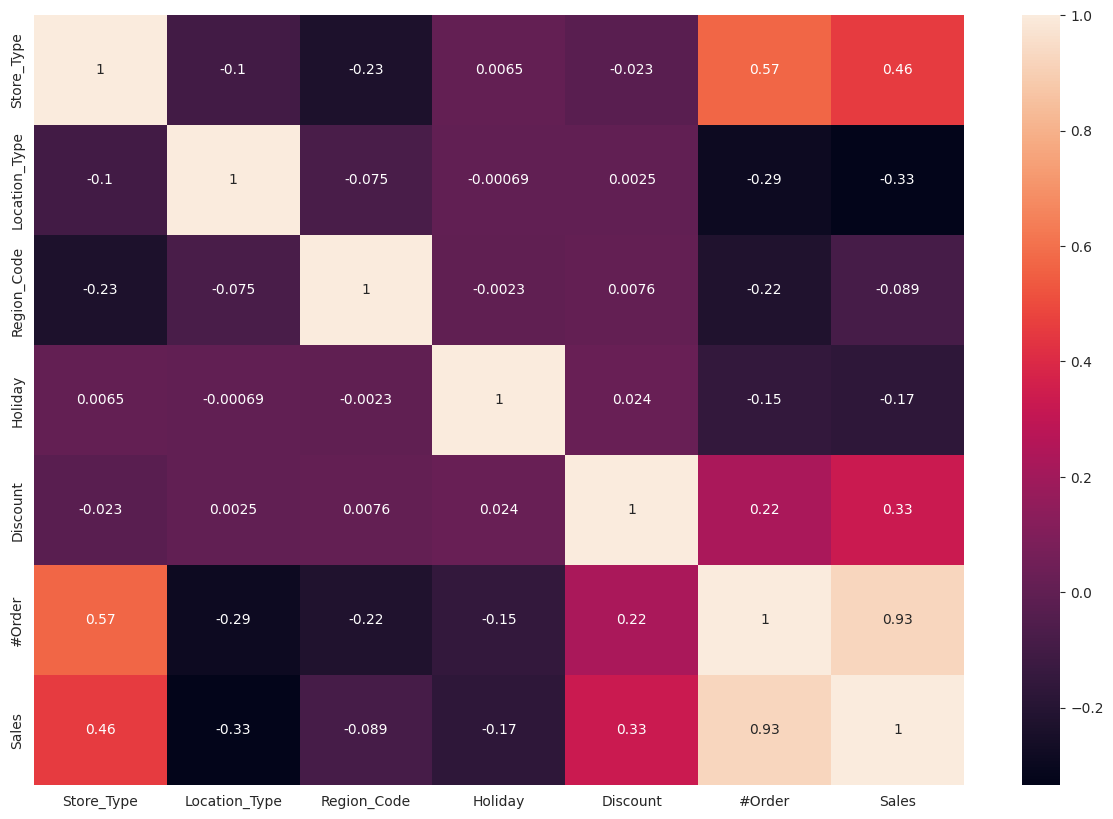

In [ ]:
sns.heatmap(std_reg_data.corr(),annot = True)
plt.show()

## Checking for multi-colinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF',ascending = False)
vif

,Features,VIF
5,#Order,1.89
0,Store_Type,1.59
1,Location_Type,1.14
4,Discount,1.11
2,Region_Code,1.09
3,Holiday,1.05


Since all the vif scores are below 2 so we can say that the features are not multi-colinear

## Checking for Normality: The residuals should be normally distributed

In [ ]:
residuals = y_test-y_hat
print('Mean of residuals : ',np.mean(residuals))

Mean of residuals :  -0.00011923356712785773


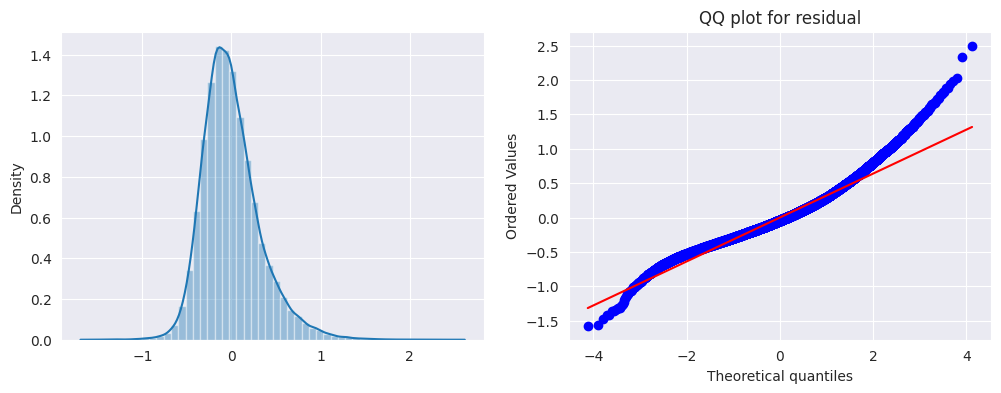

In [ ]:
residuals = np.array(residuals)
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
sns.distplot(residuals)

plt.subplot(1,2,2)
stats.probplot(residuals.reshape(-1),plot = plt)
plt.title("QQ plot for residual")
plt.show()

### 4. No Heteroscedasticity: The variance of errors is constant across all levels of independent variables.

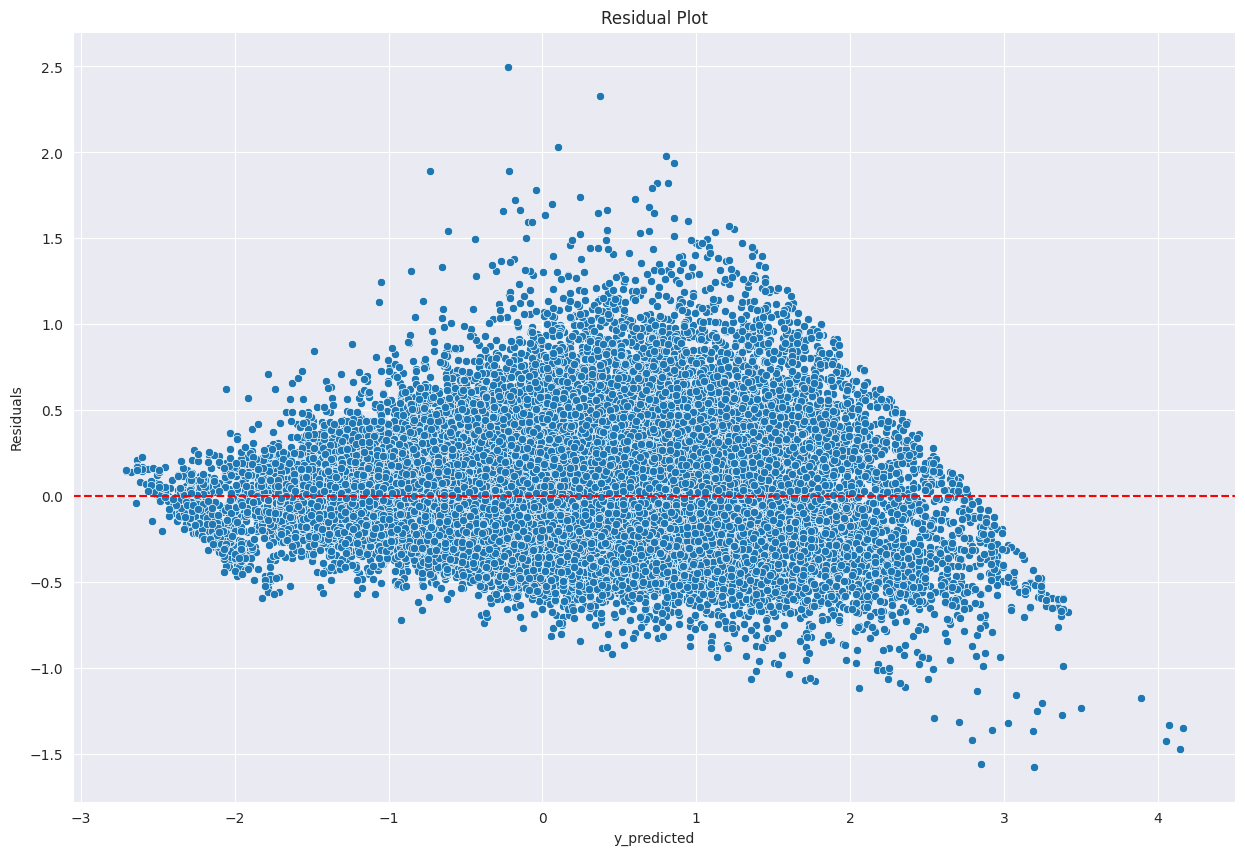

In [ ]:
sns.scatterplot(x = y_hat.reshape((-1,)),y = residuals.reshape((-1,)))
plt.title('Residual Plot')
plt.xlabel('y_predicted')
plt.ylabel('Residuals')
plt.axhline(y= 0,color = 'r',linestyle = '--')
plt.show()

### 5. No auto correlation
There is no auto correlation because in the data we dropped the date column

## Linear Regression Model with Cross Validation and Elastic Net regression

In [ ]:
def adj_r2(X,y,r2_score):
    return 1-((1-r2_score)*(X.shape[0]-1)/(X.shape[0]-X.shape[1]-1))

In [ ]:
rate_list = [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100]
train_scores = []
val_scores = []
for rate in rate_list:
    e_reg = ElasticNet(alpha = rate)
    e_reg.fit(x_train,y_train)
    train_score = adj_r2(x_train,y_train,e_reg.score(x_train,y_train))
    val_score = adj_r2(x_v,y_v,e_reg.score(x_v,y_v))
    train_scores.append(train_score)
    val_scores.append(val_score)

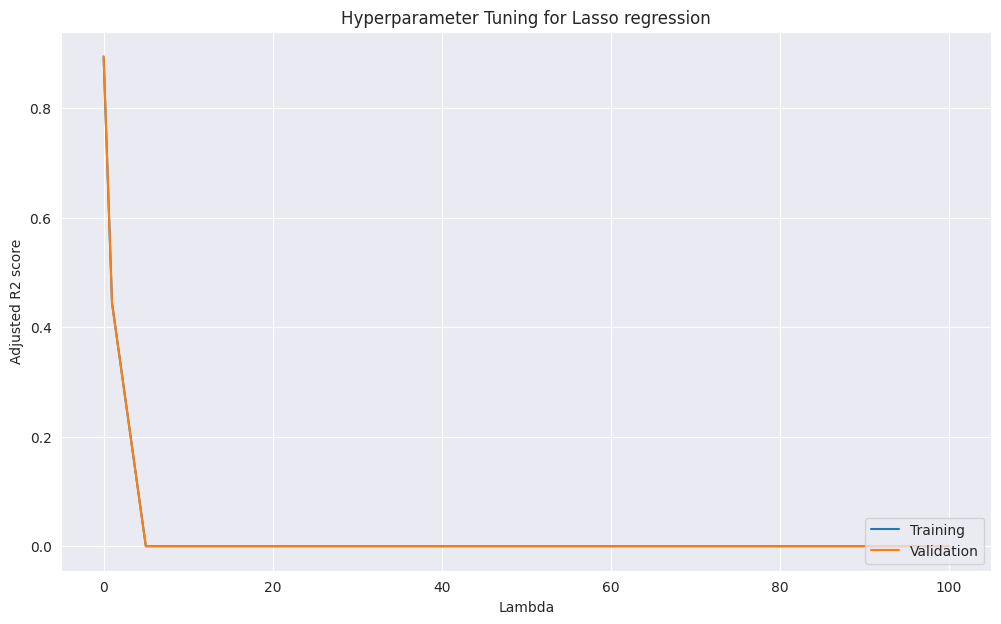

In [ ]:
plt.figure(figsize = (12,7))
plt.plot(rate_list,train_scores,label = 'Training')
plt.plot(rate_list,val_scores,label = 'Validation')
plt.legend(loc = 'lower right')
plt.xlabel('Lambda')
plt.ylabel('Adjusted R2 score')
plt.title('Hyperparameter Tuning for Lasso regression')
plt.show()

In [ ]:
rate_list[np.argmax(val_scores)]

1e-15

For lambda value of 1e-15 the adjusted r2 score was maximum. So we will train the and evaluate the model with this value of lambda

In [ ]:
el_model = ElasticNet(alpha = 1e-15)
el_model.fit(x_train,y_train)
y_el = el_model.predict(x_test)
y_test = np.array(y_test)
print('MSE: ',mean_squared_error(y_test,y_el))
print('RMSE: ',np.sqrt(mean_squared_error(y_test,y_el)))
print('MAE: ',mean_absolute_error(y_test,y_el))
print('R2 Score: ',r2_score(y_test,y_el))

MSE:  0.10644539338429111
RMSE:  0.3262597023603913
MAE:  0.2476161177430142
R2 Score:  0.8941984574447407


## XGBoost Regressor

In [ ]:
params = {
    'n_estimators':[50,100,150,200],
    'max_depth':[3,4,5,7],
    'learning_rate':[0.1,0.2,0.3],
    'subsample':[0.6,0.8,1.0],
    'colsample_bytree':[0.6,0.8,1.0]
}

xgb_r = xg.XGBRegressor(random_state = 42)
random_search = RandomizedSearchCV(xgb_r,
                                  param_distributions = params,
                                  n_iter = 10,
                                  scoring = 'accuracy',
                                  n_jobs = -1,
                                  cv = 3,
                                  verbose = 2)
random_search.fit(x_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5, 7],
                                        'n_estimators': [50, 100, 150, 200],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='accuracy', verbose=2)

In [ ]:
xgb_best = random_search.best_estimator_
pred = xgb_best.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test,pred))
mse = mean_squared_error(y_test,pred)
print('Root mean squared error: ',rmse)
print('Mean squared error: ',mse)
print('MAE: ',mean_absolute_error(y_test,pred))

Root mean squared error:  0.27837746576078864
Mean squared error:  0.07749401344339905
MAE:  0.20787973512925137


## Time Series Modeling with SARIMA

In [ ]:
series_data = sales_out_data.groupby(['Date'])['Sales'].aggregate('sum').reset_index()
series_data = series_data.set_index('Date')
## Splitting the data for training and testing the model
train = series_data.iloc[:500,:]
test = series_data.iloc[500:,:]
test_sales = test['Sales']
train_sales = train['Sales']

## Hyperparameter tuning for Sarima model

In [ ]:
import itertools
p=d=q = range(0,3)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(z[0], z[1], z[2], 12) for z in list(itertools.product(p, d, q))]

In [ ]:
best_pdq = None
best_seasonal_pdq = None
temp_model = None
best_aic = np.inf
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            temp_model = SARIMAX(train_sales,
                                order = param,
                                seasonal_order = param_seasonal
                                )
            results = temp_model.fit()
            if results.aic<best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

print(f"Best Sarima Model: ,{best_pdq},{best_seasonal_pdq},{best_aic}")

Best Sarima Model: ,(0, 1, 0),(2, 2, 2, 12),15453.491429931033


### Forecasting the sales

MAPE:  0.09507934077959652


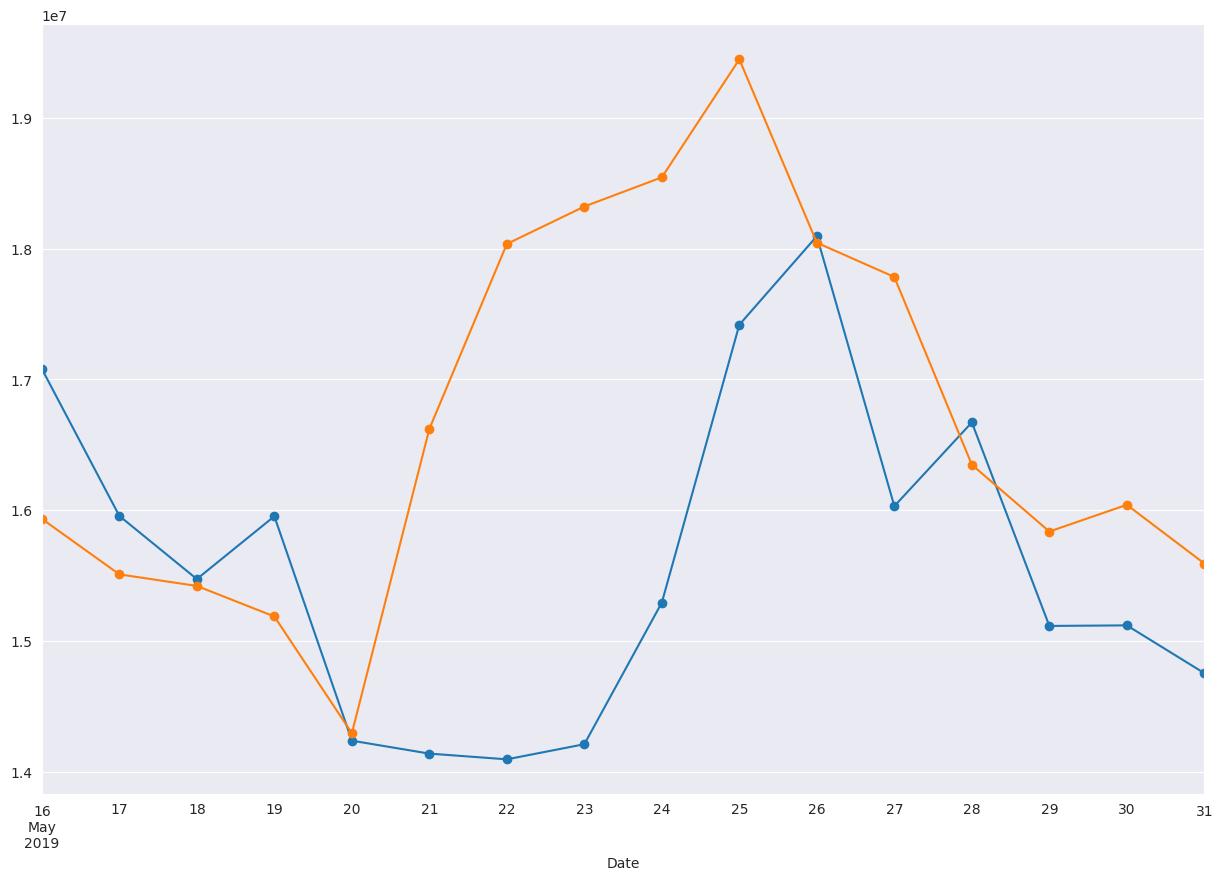

In [ ]:
model = SARIMAX(train['Sales'],
                order = (best_pdq[0],best_pdq[1],best_pdq[2]),
                seasonal_order = (best_seasonal_pdq[0],
                                  best_seasonal_pdq[1],
                                  best_seasonal_pdq[2],
                                  best_seasonal_pdq[3]))
model = model.fit()
predict = model.forecast(16)
print('MAPE: ',mean_absolute_percentage_error(test_sales,predict))
test['Sales'].plot(style = '-o',label = 'acutal')
predict.plot(style = '-o',label = 'predicted')
plt.show()

## Forecasting with SARIMAX model

MAPE:  0.09558916393657424


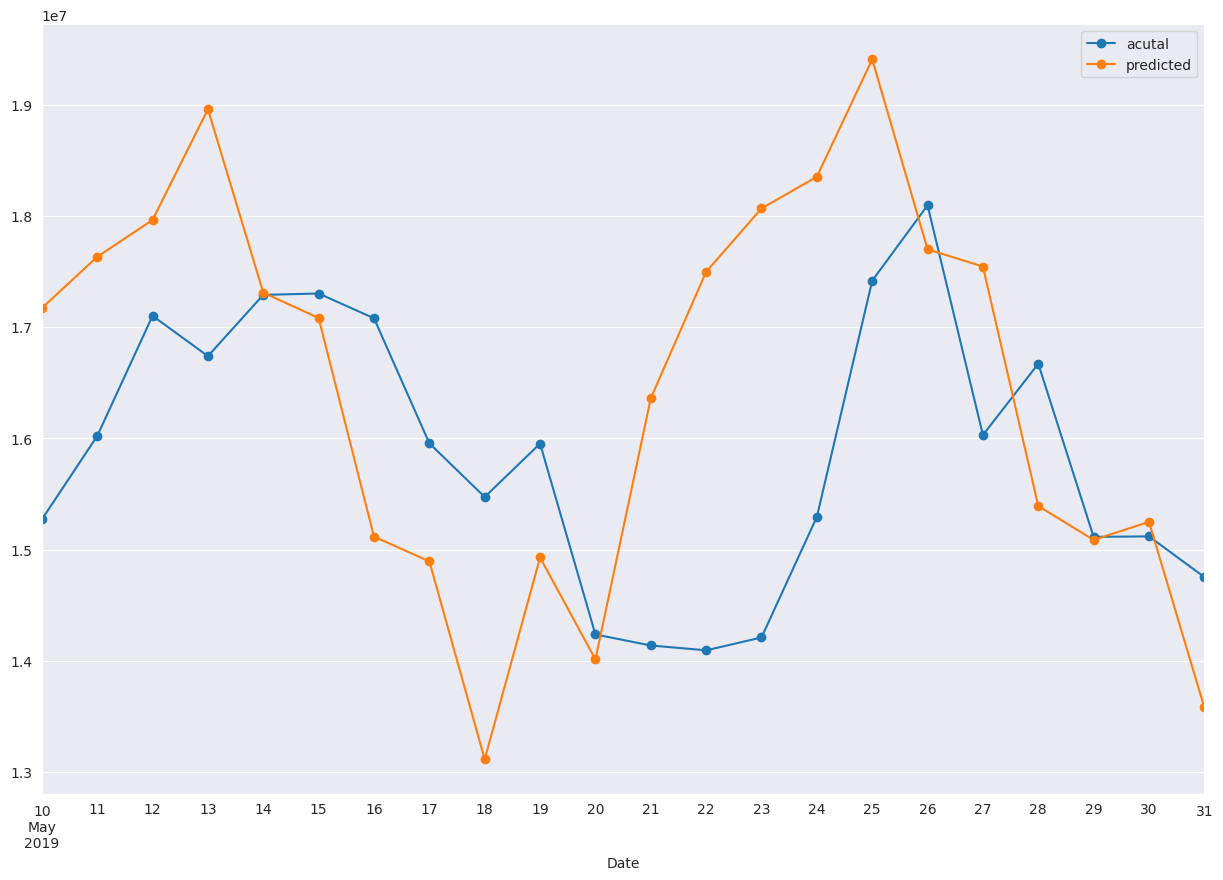

In [ ]:
data = sales_out_data.groupby(['Date'])[['Holiday','Sales']].aggregate({
    'Holiday':pd.Series.mode,
    'Sales':'sum'
})
train_data = data.iloc[:494,1]
test_data = data.iloc[494:,1]
exog_train = data.iloc[:494,0]
exog_test = data.iloc[494:,0]
model_sarimax = SARIMAX(train_data,
                        order = (0,1,0),
                       seasonal_order = (2,2,2,12),
                       exog = exog_train)
model_sarimax = model_sarimax.fit()
predict_sarimax = model_sarimax.forecast(22,exog = exog_test)
print('MAPE: ',mean_absolute_percentage_error(test_data,predict_sarimax))
test_data.plot(style = '-o',label = 'acutal')
predict_sarimax.plot(style = '-o',label = 'predicted')
plt.legend()
plt.show()

## Forecasting with FBProphet

In [ ]:
prophet_data = sales_out_data[['Date','Holiday','Sales','Discount']]
prophet_data = prophet_data.rename(columns = {'Date':'ds',
                                             'Sales':'y'})
train_p = prophet_data.iloc[:-39]
test_p = prophet_data.iloc[-39:]
test_pred = test_p.drop(['y'],axis = 1)

prophet1 = prophet.Prophet(
                           weekly_seasonality = True,
                           seasonality_mode = 'additive',
                          )
prophet1.add_seasonality(name = 'monthly',period = 30.5,
                         fourier_order = 6)
prophet1.add_regressor('Holiday')
prophet1.add_regressor('Discount')
prophet1.fit(train_p)
forecast_prophet = prophet1.predict(test_pred)
print('MAPE: ',mean_absolute_percentage_error(test_p['y'],forecast_prophet['yhat']))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprphx5rbz/gi084s6w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprphx5rbz/92emjwvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86244', 'data', 'file=/tmp/tmprphx5rbz/gi084s6w.json', 'init=/tmp/tmprphx5rbz/92emjwvh.json', 'output', 'file=/tmp/tmprphx5rbz/prophet_modelpbhqdx13/prophet_model-20240811020714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:07:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:09:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE:  0.26017067218003476


So we will pickle the best forecasting model to use it for our stream lit app. So the best model came out to be the sarima model, which had the lowest mape.

In [ ]:
pickle.dump(model,open('sarima.pkl','wb'))

In [ ]:
pickle.dump(model_sarimax,open('sarimax.pkl','wb'))